<a href="https://colab.research.google.com/github/1900690/pest-object-detection/blob/main/%E2%91%A0AI%E5%AD%A6%E7%BF%92%E7%94%A8%E3%83%87%E3%83%BC%E3%82%BF%E4%BD%9C%E6%88%90%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6_0.0.9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**学習に用いる画像を用意する**

## 1.学習に用いる画像を撮影する


*   学習に使う画像はできるだけ多いほうが良い、検出するもの一種類に対し約１０００枚必要

　　　[出典:YOLOv3の独自モデル学習の勘所](https://www.nakasha.co.jp/future/ai/yolov3train.html#:~:text=%E3%81%A9%E3%82%8C%E3%81%8F%E3%82%89%E3%81%84%E3%81%AE,%E3%82%92%E6%B1%82%E3%82%81%E3%82%8B%E5%A0%B4%E5%90%88%EF%BC%89)
*   ただし画像の枚数を後で増やす手段（[オーグメンテーション](https://www.codexa.net/data_augmentation_python_keras/#:~:text=CNN%E3%82%92%E6%A7%8B%E7%AF%89%EF%BC%89-,Data%20Augmentation%E3%81%A8%E3%81%AF,%E3%81%A6%E3%81%84%E3%81%BE%E3%81%99%E3%80%82%EF%BC%88%E5%8F%82%E8%80%83%EF%BC%9A%E3%83%95%E3%83%AA%E3%83%BC%E5%86%99%E7%9C%9F%E7%B4%A0%E6%9D%90%E3%81%B1%E3%81%8F%E3%81%9F%E3%81%9D%EF%BC%89,-%E5%9B%B31%E3%81%AB)）もあるので初めは１００枚用意する位で良い



##2.画像にアノテーションする

*   画像の中のどこに害虫がいるのか印をつける（これを[アノテーション](https://aismiley.co.jp/ai_news/what-is-annotation-that-is-often-heard-in-ai/#:~:text=%E3%83%BB%E7%94%BB%E5%83%8F%E3%83%BB%E6%98%A0%E5%83%8F%E3%83%87%E3%83%BC%E3%82%BF,%E3%81%AE%E4%B8%80%E3%81%A4%E3%81%A7%E3%81%99%E3%80%82)と言う）
*   アノテーションを行うにはウェブサイトの[fastlabel](https://fastlabel.ai/)にアクセスし画像のアップロードを行う
*   詳しいやり方は[fastlabelのクイックスタートドキュメント](https://docs.fastlabel.ai/docs/quick-start)を参照




##3.アノテーション済みデータをダウンロード

*   アノテーションが終わったらfastlabelから[データをエクスポート](https://docs.fastlabel.ai/docs/export-training-datasets)する
*  **画像出力**の項目を **オリジナル**と **マスク－ダイレクトカラー**とすることでオリジナルの画像と[ダイレクトカラー画像](https://www.webtech.co.jp/blog/optpix_labs/pic101/3119/#:~:text=%E3%81%8C%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%E3%80%82-,%E3%83%80%E3%82%A4%E3%83%AC%E3%82%AF%E3%83%88%E3%82%AB%E3%83%A9%E3%83%BC%E7%94%BB%E5%83%8F,%E8%89%B2%E6%83%85%E5%A0%B1%E3%82%92%0A%E7%9B%B4%E6%8E%A5%E6%8C%81%E3%81%A3%E3%81%A6%E3%81%84%E3%82%8B%E5%BD%A2%E5%BC%8F%E3%81%AE%E7%94%BB%E5%83%8F%E3%81%A7%E3%81%99%E3%80%82,-%E3%82%A6%E3%82%A7%E3%83%96%E3%81%A7%E4%BD%BF%E7%94%A8)をダウンロードすることができる
*   ダイレクトカラー画像には害虫の印のデータが記録されている
*   ダウンロードしたファイルは両方とも解凍しておく

#**画像の加工を行う**

##1.データをgoogle colaboratoryに取り込み
*   オリジナルの画像とダイレクトカラー画像をそれぞれgoogle colaboratoryにアップロードする
*   各項目のスクリーンショット (3).pngを押し、**ファイル選択**を押してアップロードする画像を選択する
*   ダイレクトカラー画像のフォルダには[instance_segmentations](https://tt-tsukumochi.com/archives/3564#:~:text=%E3%81%8C%E5%8F%AF%E8%83%BD%E3%81%A7%E3%81%99%E3%80%82-,%E3%82%A4%E3%83%B3%E3%82%B9%E3%82%BF%E3%83%B3%E3%82%B9%20%E3%82%BB%E3%82%B0%E3%83%A1%E3%83%B3%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3,%E3%82%92%E5%88%A5%E3%80%85%E3%81%AE%E7%89%A9%E4%BD%93%E3%81%A8%E8%AA%8D%E8%AD%98%E3%81%99%E3%82%8B%E3%81%93%E3%81%A8%E3%81%8C%E5%8F%AF%E8%83%BD%E3%81%A7%E3%81%99%E3%80%82,-%E3%83%91%E3%83%8E%E3%83%97%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%20%E3%82%BB%E3%82%B0%E3%83%A1%E3%83%B3%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3)と[semantic_segmentations](https://tt-tsukumochi.com/archives/3564#:~:text=%E7%B4%B9%E4%BB%8B%E3%81%97%E3%81%BE%E3%81%99%E3%80%82-,%E3%82%BB%E3%83%9E%E3%83%B3%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%20%E3%82%BB%E3%82%B0%E3%83%A1%E3%83%B3%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3,%E3%81%AA%E3%81%A9%E4%B8%8D%E5%AE%9A%E5%BD%A2%E3%81%AE%E9%A0%98%E5%9F%9F%E3%82%92%E6%A4%9C%E5%87%BA%E3%81%99%E3%82%8B%E3%81%93%E3%81%A8%E3%81%8C%E5%8F%AF%E8%83%BD%E3%81%A7%E3%81%99%E3%80%82,-%E3%82%A4%E3%83%B3%E3%82%B9%E3%82%BF%E3%83%B3%E3%82%B9%20%E3%82%BB%E3%82%B0%E3%83%A1%E3%83%B3%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3)の二つがあるが必要なのはinstance_segmentationsの画像

In [ ]:
#@title オリジナル画像をアップロード
#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
import glob


#データを入れるためのフォルダを作成（すでにフォルダがある場合は消去する）
if os.path.exists('/content/originals_test'):
  shutil.rmtree('/content/originals_test')
if not os.path.exists('/content/originals_test'):
    os.makedirs('/content/originals_test')

#カレントディレクトリを移動
%cd -q '/content/originals_test/'

#データをアップロード
from google.colab import files
uploaded = files.upload()

#ファイルをまとめてリネーム
path = '/content/originals_test/'
files = glob.glob(path + '/*')
for f in files:
    os.rename(f, os.path.join(path, 'img_' + os.path.basename(f)))

#元のディレクトリに戻る
%cd -q '/content/'

Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 1.jpg to 1.jpg


In [ ]:
#@title ダイレクトカラー画像をアップロード
#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
import glob

#データを入れるためのフォルダを作成（すでにフォルダがある場合は消去する）
if os.path.exists('/content/instance_segmentations'):
  shutil.rmtree('/content/instance_segmentations')
if not os.path.exists('/content/instance_segmentations'):
    os.makedirs('/content/instance_segmentations')

#カレントディレクトリを移動
%cd -q '/content/instance_segmentations'

#データをアップロード
from google.colab import files
uploaded = files.upload()

#ファイルをまとめてリネーム
path = '/content/instance_segmentations'
files = glob.glob(path + '/*')
for f in files:
    os.rename(f, os.path.join(path, 'img_' + os.path.basename(f)))

#元のディレクトリに戻る
%cd -q '/content/'

Saving 2.png to 2.png
Saving 1.png to 1.png
Saving 3.png to 3.png


##2.画像の背景を消去する
*   画像の背景は物体検出を行う際の精度低下の原因となるため取り除く

　　　[出典:物体認識における背景の有無による学習効果に関する考察](https://www.osaka-kyoiku.ac.jp/~challeng/SIG-Challenge-044/SigChallenge-044-06.pdf)
*   pythonで使える[rembg](https://github.com/danielgatis/rembg)という[ライブラリ](https://wa3.i-3-i.info/word1473.html#:~:text=%E3%83%A9%E3%82%A4%E3%83%96%E3%83%A9%E3%83%AA%EF%BC%88%E8%8B%B1%EF%BC%9Alibrary,%E3%81%A7%E3%81%99%E3%80%82)があるのでインストールして使用する



In [ ]:
#@title rembgをインストール
#rembgをインストール
!pip -q install rembg
#新しくインストールしたライブラリを働かせるためにランタイムを一度リセット
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title 背景消去を行う
#ライブラリをインポート
from rembg import remove
import cv2
import shutil
import os

#背景処理前の画像を分離するためにフォルダを作って移動させる
if not os.path.exists('/content/originals/'):
  shutil.copytree('/content/originals_test/','/content/originals/')
  shutil.rmtree('/content/originals_test/')
  os.mkdir('/content/originals_test/')
read_folda_name='/content/originals/'
read_folda = os.listdir(read_folda_name)

#背景消去
for imgname in read_folda:
  input = cv2.imread('/content/originals/'+imgname)
  output = remove(input)
  cv2.imwrite('/content/originals_test/'+imgname, output)

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 49.1GB/s]


##3.学習に用いる画像を増やす
*   害虫は画像全体の面積に対して大きさがかなり小さい。今回使用するYOLOというAIは小さい物体を見つけ出すのが苦手である
*   害虫の画像に対する大きさを大きくするために画像を分割し、分割後の画像から病害虫を見つけ出す方法がある

　　　[出典：Evaluation of YOLO Models with Sliced Inference for Small Object Detection](https://deepsquare.jp/2022/05/sahi-experiment/)

*   害虫を中心として切り取ることで必ず害虫が映っている画像とすることができる
*   切り取る際に中心部分からずらしたり、回転させたりすることで学習画像の枚数を増やす


切り取り方法の図

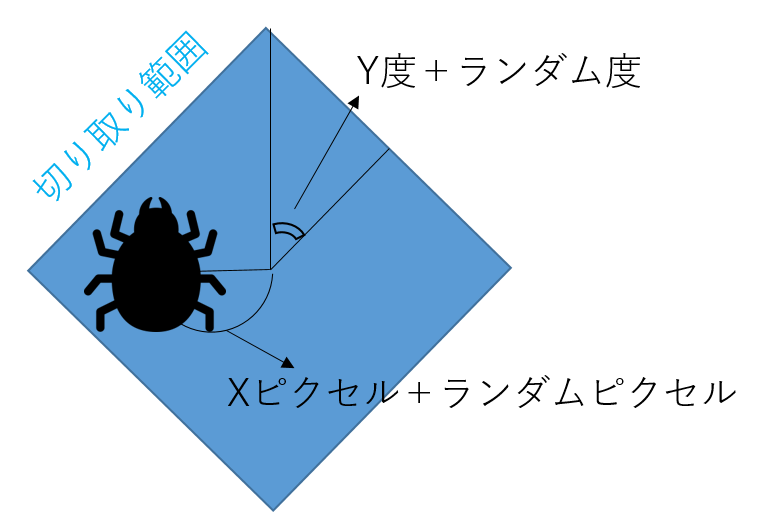

In [ ]:
#@title ダイレクトカラー画像から害虫の位置をエクセルにまとめる
#ライブラリをインポート
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import measure
import csv
import glob
import os

#画像の名前を読み込み
read_files_name='/content/instance_segmentations/*'
read_files = glob.glob(read_files_name)

#インデックスカラー化した画像を入れるフォルダを作成
if not os.path.exists('/content/index_coler/'):
  os.mkdir('/content/index_coler/')

#作るエクセルファイルの見出し行を作成
data = [["Name","Type","Value","x1","y1","x2","y2","Attributes","color_number","color_area","center_name"],]
with open("mask_bbox.csv", "w") as file:
        writer = csv.writer(file)
        writer.writerows(data)

#処理を画像の枚数分繰り返す
for file_name in read_files:
  fname = file_name #画像ファイル名
  img = np.array(Image.open(fname))
  NAME=fname[32:-4]

  #numpy形式からpil形式へ変換
  im = Image.fromarray(img)
  #ダイレクトカラーからインデックスカラーへ変換
  c = im.getcolors(im.width * im.height)#この関数はpil形式でしか使えない
  h,w=np.array(im).shape[:2]
  indexcoler=np.zeros((h,w))
  for coler in range(len(c)):
     split=np.zeros((h,w,3))
     split[:,:,0]=np.full((h, w), c[coler][1][0])
     split[:,:,1]=np.full((h, w), c[coler][1][1])
     split[:,:,2]=np.full((h, w), c[coler][1][2])
     truefalse=np.equal(split,im)
     zeroone = np.where(truefalse == True, 1, 0)
     after=zeroone[:,:,0]+zeroone[:,:,1]+zeroone[:,:,2]
     split_after = np.where(after == 3, coler, 0)
     indexcoler=indexcoler+split_after
  #pil形式からnumpy形式へ変換
  img = np.array(indexcoler)
  
  #色を二値化（白黒の二色にする）
  c = Image.fromarray(img).getcolors(Image.fromarray(img).width * Image.fromarray(img).height)
  img_binary = np.where(img == max(c)[1], 0, 255)
  
  #color_numberの順番を面積が大きいほうから０を割り振る（インデックス０番は必ず背景色の黒になるようにする）
  img2=np.zeros_like((img)) 
  for i in range(int(sorted(c,reverse=True)[0][1])+1):
    img2= np.where(img ==int(sorted(c,reverse=True)[i][1]),int((sorted(c,reverse=True)[0][1])-(sorted(c,reverse=True)[i][1])),img2)
  c2 = Image.fromarray(img2).getcolors(Image.fromarray(img2).width * Image.fromarray(img2).height)

  #次のセルで使うためにインデックスカラー画像を保存
  cv2.imwrite("/content/index_coler/"+file_name[32:],img2)

  #各害虫の位置の座標を求める
  #contours = measure.find_contours(img, 0.0)
  contours_binary = measure.find_contours(img_binary, 0.0)

  #座標の情報をエクセルファイルに書き込んでいく
  for number in list(range(len(contours_binary))):

    y_min = int(np.amin(contours_binary[number],axis=0)[0])
    y_max = int(np.amax(contours_binary[number],axis=0)[0])
    x_min = int(np.amin(contours_binary[number],axis=0)[1])
    x_max = int(np.amax(contours_binary[number],axis=0)[1])
    #color_number = img2[int((y_min+y_max)/2),int((x_min+x_max)/2)]
    color_number = np.amax(img2[y_min:y_max+1,x_min:x_max+1])
    coler=str(int(color_number))
    area  = (y_max-y_min)*(x_max-x_min)
    centername=NAME+"_"+str('{0:04d}'.format(int((x_max+x_min)/2)))+"_"+str('{0:04d}'.format(int((y_max+y_min)/2)))
    data=[[NAME,"bbox","mite",x_min,y_min,x_max,y_max,"",coler,area,centername]]
    
    with open("mask_bbox.csv",mode="a", newline="") as file:
          writer = csv.writer(file)
          writer.writerows(data)

In [ ]:
#@title エクセルを元に画像から必要部分を切り出す
#制御用スイッチ
original_switch=True#オリジナル画像の加工を行うかどうかを決めるスイッチ
mask_switch=True#マスク画像の加工を行うかどうかを決めるスイッチ

shrink_switch =False#画像の縮小を行うかどうかを決めるスイッチ
#@markdown 出力される画像の一辺のサイズ（ピクセル単位）を入力　※サイズは３２の倍数が良い
一辺の長さ=192 #@param {type:"integer"}
cut_size=(一辺の長さ,一辺の長さ)

#@markdown 画像の左右反転について
左右反転する =True #@param {type:"boolean"}
flip_switch =左右反転する
flip_code=1#反転方向を決める


#@markdown ランダム変化について
#ランダム変化の割合
ランダム変化の割合=1.7#@param {type:"number"}
#ランダム変化の最小割合
random_range_low=-1*ランダム変化の割合
#ランダム変化の最大割合
random_range_up=ランダム変化の割合

回転角をランダムに変化させる=False#@param {type:"boolean"}
rotation_random_switch=回転角をランダムに変化させる
rotation_angle=range(90,360,90)

中心点をランダムに変化させる =True#@param {type:"boolean"}
shift_random_switch =中心点をランダムに変化させる
centaling_shift=range(50,151,50)

#ダニがいない部分の画像を作成するか決めるスイッチ
background_image_switch =False

#@markdown 注：細かい設定を行う場合は”コードを表示”を選択

#ライブラリをインポート
import cv2
import os
from PIL import Image
import numpy as np
import pandas as pd
import math
import random


#関数定義を定義　欲しい領域のみ回転させる。切り出しと回転が同時に行う
def rot_cut(src_img, deg, center, size):
    rot_mat = cv2.getRotationMatrix2D(center, deg, 1.0)
    rot_mat[0][2] += -center[0]+size[0]/2 # -(元画像内での中心位置)+(切り抜きたいサイズの中心)
    rot_mat[1][2] += -center[1]+size[1]/2 # 同上
    return cv2.warpAffine(src_img, rot_mat, size)

#作成したエクセルのデータを読み込み
df = pd.read_csv('/content/mask_bbox.csv')

#作業するとできてしまうゴミ（.ipynb_checkpoints）を消去
!cd '/content/originals_test'
!rm -rf `find -type d -name .ipynb_checkpoints`
!cd '/content'

if mask_switch==True:
  df = pd.read_csv('/content/mask_bbox.csv')
  output_mask="/content/cutmask/"
  if not os.path.exists(output_mask):
    os.mkdir(output_mask)
  read_files_name_mask='/content/index_coler/'
  read_files_mask = os.listdir(read_files_name_mask)

if original_switch==True:
  output_original="/content/cut/"
  if not os.path.exists(output_original):
    os.mkdir(output_original)
  read_files_name_original='/content/originals_test/'
  read_files_original = os.listdir(read_files_name_original)

if original_switch==True and mask_switch==True:
  for file_name_original in read_files_original:
    for mite_zahyo in range(len(df[df['Name'] == file_name_original[:-4]])):#center用に座標を抽出
      x_zahyo=(df[df['Name'] == file_name_original[:-4]] ["x1"].iloc[mite_zahyo]+df[df['Name'] ==file_name_original[:-4]] ["x2"].iloc[mite_zahyo])/2
      y_zahyo=(df[df['Name'] == file_name_original[:-4]] ["y1"].iloc[mite_zahyo]+df[df['Name'] ==file_name_original[:-4]] ["y2"].iloc[mite_zahyo])/2

      src_img = cv2.imread(read_files_name_original+file_name_original)
      src_img_mask = cv2.imread(read_files_name_mask+file_name_original[:-4]+".png")

      src_img_mask =src_img_mask[:,:,0]#*50#切り取りがうまくいっているかを調べる際に５０を掛ける

      #切り取り範囲が元の画像より大きいかチェック
      check_size=(h,w)
      if check_size[0]<=cut_size[0] or check_size[1]<=cut_size[1]:
        #0を定義するため+1
        src_img_mask=src_img_mask+1
        #最大の面積に格納されている値を出す
        max_area=Image.fromarray(src_img_mask).getcolors(Image.fromarray(src_img_mask).width * Image.fromarray(src_img_mask).height)
        max_number=np.sort(max_area,axis=0)[::-1][0][1]
        #最大の面積の値を０に置き換え
        src_img_mask = np.where(src_img == max_number, 0, src_img_mask)

      for nizyuhuriko_x in centaling_shift:
        for nizyuhuriko_y in centaling_shift:
          for i in rotation_angle:
            #ランダム数値を作成
            if rotation_random_switch==True:
              random_numberθ=random.uniform(random_range_low,random_range_up)
            else:
              random_numberθ=0
            
            if shift_random_switch==True:
              random_number_x=random.uniform(random_range_low,random_range_up)
              random_number_y=random.uniform(random_range_low,random_range_up)
              random_number_flip_x=random.uniform(random_range_low,random_range_up)
              random_number_flip_y=random.uniform(random_range_low,random_range_up)
              random_number_shrink_x=random.uniform(random_range_low,random_range_up)
              random_number_shrink_y=random.uniform(random_range_low,random_range_up)
            else:
              random_number_x=1
              random_number_y=1
              random_number_flip_x=1
              random_number_flip_y=1
              random_number_shrink_x=1
              random_number_shrink_y=1
            if background_image_switch==True:
              h_background,w_background=np.array(src_img).shape[:2]
              cut_background_x=random.uniform(cut_size[0]/2,w_background-cut_size[0]/2)
              cut_background_y=random.uniform(cut_size[1]/2,h_background-cut_size[1]/2)



            #center=(x_zahyo+nizyuhuriko_x+nizyuhuriko_x*random_number_x,y_zahyo+nizyuhuriko_y+nizyuhuriko_y*random_number_y)#回転中心はCSVから取得
            center=(int(x_zahyo+nizyuhuriko_x*random_number_x),int(y_zahyo+nizyuhuriko_y*random_number_y))
            if background_image_switch==True:
              center_background=(int(cut_background_x),int(cut_background_y))


            cutimage_original=rot_cut(src_img, i+i*random_numberθ,center, cut_size) 
            savename_original=output_original+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int(nizyuhuriko_x*random_number_x)))+"_y"+str('{0:04d}'.format(int(nizyuhuriko_y*random_number_y)))+"_o.jpg"          
            cv2.imwrite(savename_original,cutimage_original)
            if background_image_switch==True:
              cutimage_original_background=rot_cut(src_img, i,center_background, cut_size) 
              savename_original_background=output_original+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(cut_background_x)))+"_"+str('{0:04d}'.format(int(cut_background_y)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int("0")))+"_y"+str('{0:04d}'.format(int("0")))+"_b.jpg"          
              cv2.imwrite(savename_original_background,cutimage_original_background)

            if flip_switch==True:
              (heignt_f,wide_f)=np.array(src_img).shape[:2]
              if flip_code==0:
                center=(int(x_zahyo+nizyuhuriko_x*random_number_flip_x),int(heignt_f-y_zahyo+nizyuhuriko_y*random_number_flip_y))
              if flip_code>0:
                center=(int(wide_f-x_zahyo+nizyuhuriko_x*random_number_flip_x),int(y_zahyo+nizyuhuriko_y*random_number_flip_y))
              if flip_code<0:
                center=(int(wide_f-x_zahyo+nizyuhuriko_x*random_number_flip_x),int(heignt_f-y_zahyo+nizyuhuriko_y*random_number_flip_y))
                
              cutimage_revalse_original=rot_cut(cv2.flip(src_img, flip_code), i+i*random_numberθ,center, cut_size) 
              savename_reverse_original=output_original+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int(nizyuhuriko_x*random_number_flip_x)))+"_y"+str('{0:04d}'.format(int(nizyuhuriko_y*random_number_flip_y)))+"_f.jpg"
              cv2.imwrite(savename_reverse_original,cutimage_revalse_original)
            if shrink_switch ==True:
              center_s=(int((x_zahyo+nizyuhuriko_x*random_number_shrink_x)/2),int((y_zahyo+nizyuhuriko_y*random_number_shrink_y)/2))
              (heignt_s,wide_s)=np.array(src_img).shape[:2]
              cutimage_shrink_original=rot_cut(cv2.resize(src_img,dsize=(int(wide_s/2),int(heignt_s/2))), i+i*random_numberθ,center_s, (int(cut_size[0]/2),int(cut_size[1]/2)))               
              savename_shrink_original=output_original+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int(nizyuhuriko_x*random_number_shrink_x)))+"_y"+str('{0:04d}'.format(int(nizyuhuriko_y*random_number_shrink_y)))+"_s.jpg"
              cv2.imwrite(savename_shrink_original,cutimage_shrink_original)

            center=(int(x_zahyo+nizyuhuriko_x*random_number_x),int(y_zahyo+nizyuhuriko_y*random_number_y))
            if background_image_switch==True:
              center_background=(int(cut_background_x),int(cut_background_y))
            
            cutimage_crear=rot_cut(src_img_mask,i+i*random_numberθ,center,cut_size).astype(int)
            #cutimage_crear=np.ceil(cutimage_crear)#*1/max_number*255#切り上げする
            cutimage_crear=np.floor(cutimage_crear)#*1/max_number*255#切り捨てする
            savename=output_mask+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int(nizyuhuriko_x*random_number_x)))+"_y"+str('{0:04d}'.format(int(nizyuhuriko_y*random_number_y)))+"_o.png"
            cv2.imwrite(savename,cutimage_crear)
            if background_image_switch==True:
              cutimage_crear_background=rot_cut(src_img_mask,i,center_background,cut_size).astype(int)
              #cutimage_crear=np.ceil(cutimage_crear)#*1/max_number*255#切り上げする
              cutimage_crear_background=np.floor(cutimage_crear_background)#*1/max_number*255#切り捨てする
              savename_background=output_mask+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(cut_background_x)))+"_"+str('{0:04d}'.format(int(cut_background_y)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int("0")))+"_y"+str('{0:04d}'.format(int("0")))+"_b.png"
              cv2.imwrite(savename_background,cutimage_crear_background)
            if flip_switch==True:
              (heignt_f,wide_f)=np.array(src_img_mask).shape[:2]
              if flip_code==0:
                center=(int(x_zahyo+nizyuhuriko_x*random_number_flip_x),int(heignt_f-y_zahyo+nizyuhuriko_y*random_number_flip_y))
              if flip_code>0:
                center=(int(wide_f-x_zahyo+nizyuhuriko_x*random_number_flip_x),int(y_zahyo+nizyuhuriko_y*random_number_flip_y))
              if flip_code<0:
                center=(int(wide_f-x_zahyo+nizyuhuriko_x*random_number_flip_x),int(heignt_f-y_zahyo+nizyuhuriko_y*random_number_flip_y))

              cutimage_crear_revalse=rot_cut(cv2.flip(src_img_mask, flip_code), i+i*random_numberθ,center, cut_size) 
              savename_reverse=output_mask+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int(nizyuhuriko_x*random_number_flip_x)))+"_y"+str('{0:04d}'.format(int(nizyuhuriko_y*random_number_flip_y)))+"_f.png"
              cv2.imwrite(savename_reverse,cutimage_crear_revalse)
            if shrink_switch ==True:
              center_s=(int((x_zahyo+nizyuhuriko_x*random_number_shrink_x)/2),int((y_zahyo+nizyuhuriko_y*random_number_shrink_y)/2))
              (heignt_s,wide_s)=np.array(src_img_mask).shape[:2]
              cutimage_shrink_mask=rot_cut(cv2.resize(src_img_mask,dsize=(int(wide_s/2),int(heignt_s/2))), i+i*random_numberθ,center_s, (int(cut_size[0]/2),int(cut_size[1]/2)))               
              savename_shrink_mask=output_mask+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:04d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:04d}'.format(int(nizyuhuriko_x*random_number_shrink_x)))+"_y"+str('{0:04d}'.format(int(nizyuhuriko_y*random_number_shrink_y)))+"_s.png"
              cv2.imwrite(savename_shrink_mask,cutimage_shrink_mask)

if original_switch==True and mask_switch==False:
  for file_name_original in read_files_original:
    for mite_zahyo in range(len(df[df['Name'] == file_name_original[:-4]])):#center用に座標を抽出
      x_zahyo=(df[df['Name'] == file_name_original[:-4]] ["x1"].iloc[mite_zahyo]+df[df['Name'] ==file_name_original[:-4]] ["x2"].iloc[mite_zahyo])/2
      y_zahyo=(df[df['Name'] == file_name_original[:-4]] ["y1"].iloc[mite_zahyo]+df[df['Name'] ==file_name_original[:-4]] ["y2"].iloc[mite_zahyo])/2

      src_img = cv2.imread(read_files_name_original+file_name_original)
      for nizyuhuriko_x in centaling_shift:
        for nizyuhuriko_y in centaling_shift:
          for i in rotation_angle:

            #ランダム作成
            if rotation_random_switch==True:
              random_numberθ=random.uniform(random_range_low,random_range_up)
            else:
              random_numberθ=0
            
            if shift_random_switch==True:
              random_number_x=random.uniform(random_range_low,random_range_up)
              random_number_y=random.uniform(random_range_low,random_range_up)
            else:
              random_number_x=0
              random_number_y=0

            center=(x_zahyo+nizyuhuriko_x+nizyuhuriko_x*random_number_x,y_zahyo+nizyuhuriko_y+nizyuhuriko_y*random_number_y)#回転中心はCSVから取得

            cutimage_original=rot_cut(src_img, i+i*random_numberθ,center, cut_size) 
            savename_original=output_original+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:03d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:03d}'.format(int(nizyuhuriko_x+nizyuhuriko_x*random_number_x)))+"_y"+str('{0:03d}'.format(int(nizyuhuriko_y+nizyuhuriko_y*random_number_y)))+"_o.jpg"
            cv2.imwrite(savename_original,cutimage_original)
            if flip_switch==True:
              cutimage_revalse_original = cv2.flip(cutimage_original, flip_code)
              savename_reverse_original=output_original+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:03d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:03d}'.format(int(nizyuhuriko_x+nizyuhuriko_x*random_number_x)))+"_y"+str('{0:03d}'.format(int(nizyuhuriko_y+nizyuhuriko_y*random_number_y)))+"_f.jpg"
              cv2.imwrite(savename_reverse_original,cutimage_revalse_original)
            if shrink_switch ==True:
              (heignt_s,wide_s)=np.array(cutimage_original).shape[:2]
              cutimage_shrink_original=cv2.resize(cutimage_original,dsize=(int(heignt_s/2),int(wide_s/2)))
              savename_shrink_original=output_original+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:03d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:03d}'.format(int(nizyuhuriko_x+nizyuhuriko_x*random_number_x)))+"_y"+str('{0:03d}'.format(int(nizyuhuriko_y+nizyuhuriko_y*random_number_y)))+"_s.jpg"
              cv2.imwrite(savename_shrink_original,cutimage_shrink_original)

if original_switch==False and mask_switch==True:
  for file_name_mask in read_files_mask:
    for mite_zahyo in range(len(df[df['Name'] == file_name_mask[:-4]])):#center用に座標を抽出
      x_zahyo=(df[df['Name'] == file_name_mask[:-4]] ["x1"].iloc[mite_zahyo]+df[df['Name'] ==file_name_mask[:-4]] ["x2"].iloc[mite_zahyo])/2
      y_zahyo=(df[df['Name'] == file_name_mask[:-4]] ["y1"].iloc[mite_zahyo]+df[df['Name'] ==file_name_mask[:-4]] ["y2"].iloc[mite_zahyo])/2

      src_img_mask = cv2.imread(read_files_name_mask+file_name_mask)

      src_img_mask =src_img_mask[:,:,0]


      #切り取り範囲が元の画像より大きいかチェック
      check_size=(h,w)
      if check_size[0]<=cut_size[0] or check_size[1]<=cut_size[1]:
        #0を定義するため+1
        src_img_mask=src_img_mask+1
        #最大の面積に格納されている値を出す
        max_area=Image.fromarray(src_img_mask).getcolors(Image.fromarray(src_img_mask).width * Image.fromarray(src_img_mask).height)
        max_number=np.sort(max_area,axis=0)[::-1][0][1]
        #最大の面積の値を０に置き換え
        src_img_mask = np.where(src_img == max_number, 0, src_img_mask)

      for nizyuhuriko_x in centaling_shift:
        for nizyuhuriko_y in centaling_shift:
          for i in rotation_angle:
            #ランダム作成
            if rotation_random_switch==True:
              random_numberθ=random.uniform(random_range_low,random_range_up)
            else:
              random_numberθ=0
            
            if shift_random_switch==True:
              random_number_x=random.uniform(random_range_low,random_range_up)
              random_number_y=random.uniform(random_range_low,random_range_up)
            else:
              random_number_x=0
              random_number_y=0

            center=(x_zahyo+nizyuhuriko_x+nizyuhuriko_x*random_number_x,y_zahyo+nizyuhuriko_y+nizyuhuriko_y*random_number_y)#回転中心はCSVから取得

            cutimage_crear=rot_cut(src_img_mask,i+i*random_numberθ,center,cut_size).astype(int)
            #cutimage_crear=np.ceil(cutimage_crear)#*1/max_number*255#切り上げする
            cutimage_crear=np.floor(cutimage_crear)#*1/max_number*255#切り捨てする
            savename=output_mask+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:03d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:03d}'.format(int(nizyuhuriko_x+nizyuhuriko_x*random_number_x)))+"_y"+str('{0:03d}'.format(int(nizyuhuriko_y+nizyuhuriko_y*random_number_y)))+"_o.png"
            cv2.imwrite(savename,cutimage_crear)
            if flip_switch==True:
              cutimage_crear_revalse = cv2.flip(cutimage_crear, flip_code)
              savename_reverse=output_mask+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:03d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:03d}'.format(int(nizyuhuriko_x+nizyuhuriko_x*random_number_x)))+"_y"+str('{0:03d}'.format(int(nizyuhuriko_y+nizyuhuriko_y*random_number_y)))+"_f.png"
              cv2.imwrite(savename_reverse,cutimage_crear_revalse)
            if shrink_switch ==True:
              (heignt_s,wide_s)=np.array(cutimage_crear).shape[:2]
              cutimage_shrink_mask=cv2.resize(cutimage_crear,dsize=(int(heignt_s/2),int(wide_s/2)))
              savename_shrink_mask=output_mask+file_name_original[:-4]+"_"+str('{0:04d}'.format(int(x_zahyo)))+"_"+str('{0:04d}'.format(int(y_zahyo)))+"_c"+str('{0:03d}'.format(int(i+i*random_numberθ)))+"_x"+str('{0:03d}'.format(int(nizyuhuriko_x+nizyuhuriko_x*random_number_x)))+"_y"+str('{0:03d}'.format(int(nizyuhuriko_y+nizyuhuriko_y*random_number_y)))+"_s.png"
              cv2.imwrite(savename_shrink_mask,cutimage_shrink_mask)

#全画像の害虫の数と増加割合を計算する
bairitu=1
if flip_switch ==True:
  bairitu=bairitu+1
if shrink_switch ==True:
  bairitu=bairitu+1
bairitu=bairitu*len(rotation_angle)
bairitu=bairitu*len(centaling_shift)
bairitu=bairitu*len(centaling_shift)

print("全画像の害虫の数が",int(len(df)),"匹で、増加倍率が",bairitu,"倍なので")
print("このセルを実行するたびに",int(len(df))*bairitu,"枚画像が増えます")
read_files_name_original='/content/cut/*.jpg'
read_files_original = glob.glob(read_files_name_original)
read_files_name_bbox='/content/cutmask/*.png'
read_files_bbox = glob.glob(read_files_name_bbox)
print("作成された画像の枚数は",len(read_files_original),"枚です。")

if rotation_random_switch ==False and shift_random_switch ==False:
  print("！注意！　ランダムスイッチが両方ともOFFとなっているので、セルを実行するたびに増加する画像は全く同じものとなります。")

全画像の害虫の数が 3 匹で、増加倍率が 54 倍なので
このセルを実行するたびに 162 枚画像が増えます
作成された画像の枚数は 162 枚です。


##3.害虫の位置のデータを作成


In [ ]:
#@title 作成した画像から害虫の位置をエクセルにまとめる
##@markdown  *  作成されるエクセルはcut_mask_bbox_fastlabel.csvとcut_mask_bbox_fastlabel_cread.csvの二つ

##@markdown  *  cut_mask_bbox_fastlabel_cread.csvは半分以下になった害虫の印を取り除いたもの
#ライブラリをインポート
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import measure
import csv
import glob
import pandas as pd
import math
import os

#harf用参考ＣＳＶ読み込み
df = pd.read_csv('/content/mask_bbox.csv')
#画像読み込み
read_files_name_bbox='/content/cutmask/*'
read_files_bbox = glob.glob(read_files_name_bbox)

#例外出力用フォルダ作成
if not os.path.exists('/content/exception_output/'):
  os.mkdir('/content/exception_output/')

data = [["Name","Type","Value","x1","y1","x2","y2","Attributes","color_number","color_area","harf_area","area_judge"],]
with open("cut_mask_bbox_fastlabel.csv", "w") as file:
        writer = csv.writer(file)
        writer.writerows(data)

for file_name_bbox in read_files_bbox:
  fname = file_name_bbox #画像ファイル名

  img = np.array(Image.open(fname))

  NAME=fname[17:-4]+".jpg"
  
  #インデックスの最小値が2の場合に1にする
  if np.amin(img) >=2:
    img=img-1


  #色を二値化
  c = Image.fromarray(img).getcolors(Image.fromarray(img).width * Image.fromarray(img).height)
  img_binary = np.where(img == max(c)[1], 0, 255)
  

  #分ける
  #contours = measure.find_contours(img, 0.0)
  contours_binary = measure.find_contours(img_binary, 0.0)

  for number in list(range(len(contours_binary))):

    y_min = int(np.amin(contours_binary[number],axis=0)[0])
    y_max = int(np.amax(contours_binary[number],axis=0)[0])
    x_min = int(np.amin(contours_binary[number],axis=0)[1])
    x_max = int(np.amax(contours_binary[number],axis=0)[1])
    mite_area=img[y_min:y_max,x_min:x_max]

    #切り取った後の害虫のサイズが０の場合の例外を取り除いている
    if mite_area.size == 0:
      harf_index="empty_matrix_err"
      cv2.imwrite('/content/exception_output/empty_matrix_err_'+NAME,img_binary)
      data=[[NAME,"bbox","mite",x_min,y_min,x_max,y_max,harf_index,"","","",-1]]
      with open("cut_mask_bbox_fastlabel.csv",mode="a", newline="") as file:
          writer = csv.writer(file)
          writer.writerows(data)
    else:
      color_number = np.amax(mite_area)   
      coler=str(color_number)
      area  = (y_max-y_min)*(x_max-x_min)
      
      #害虫がいない場合の例外を取り除いている
      if color_number==0:
        harf_index="color_number_0_err"
        cv2.imwrite('/content/exception_output/color_number_0_err'+NAME,img_binary)
        data=[[NAME,"bbox","mite",x_min,y_min,x_max,y_max,harf_index,0,area,"",-1]]
        with open("cut_mask_bbox_fastlabel.csv",mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerows(data)
      else:
        #画像のサイズが一定でない場合の処理
        if check_size[0]<=cut_size[0] or check_size[1]<=cut_size[1]:
          harf_index=int(df[(df['Name'] == NAME[:-34]) & (df['color_number'] == color_number-1)] ["color_area"]/2)
          if NAME[-5:-4]=="s":
            harf_index=int(harf_index/4)

        else:
          if len(df[(df['Name'] == NAME[:-34]) & (df['color_number'] == color_number)])==0:
            harf_index=0
          else: 
            harf_index=int(df[(df['Name'] == NAME[:-34]) & (df['color_number'] == color_number)] ["color_area"]/2)
          if NAME[-5:-4]=="s":
            harf_index=int(harf_index/4)

        judge=area-harf_index
        
        data=[[NAME,"bbox","mite",x_min,y_min,x_max,y_max,"",coler,area,harf_index,judge]]
        
        with open("cut_mask_bbox_fastlabel.csv",mode="a", newline="") as file:
              writer = csv.writer(file)
              writer.writerows(data)

#境目部分を処理（条件に合う行を抽出する）
df = pd.read_csv('/content/cut_mask_bbox_fastlabel.csv')
#area_judgeが０以下の場合は何らかのエラーが発生しているので取り除く
df2=df[df['area_judge'] >=0]
df2.to_csv('/content/cut_mask_bbox_fastlabel_cread.csv', index=False)

In [ ]:
#@title エクセルからYOLOに用いる位置データを作成

##@markdown ※fastlabelで確認する場合
データを出力=True 
output_fastlabel=データを出力

#ライブラリをインポート
import pandas as pd
import os
import shutil
from google.colab import files
import glob

if os.path.exists('/content/yolo_format'):
  shutil.rmtree('/content/yolo_format')
if os.path.exists("/content/annotations/"):
  shutil.rmtree("/content/annotations/")

yolo_pass="/content/annotations/"
if not os.path.exists(yolo_pass):
    os.mkdir(yolo_pass)

if output_fastlabel==True:
  with open('/content/classes.txt', 'w') as f:
    rote='mite'
    f.write(rote)


df = pd.read_csv('/content/cut_mask_bbox_fastlabel_cread.csv')
df2=df.sort_values('Name')
df3=df2.drop_duplicates(subset='Name')
index_number=df3.values.tolist()
count=1


for file_name_number in range(len(index_number)):
  for file_name_mite_number in range(len(df[df['Name']==index_number[file_name_number][0]])):

    im = Image.open("/content/cutmask/"+str(index_number[file_name_number][0][:-4])+".png")
    image_width,image_height=np.array(im).shape[:2]


    x_min=df[df['Name']==index_number[file_name_number][0]]['x1'].iloc[file_name_mite_number]
    y_min=df[df['Name']==index_number[file_name_number][0]]['y1'].iloc[file_name_mite_number]
    x_max=df[df['Name']==index_number[file_name_number][0]]['x2'].iloc[file_name_mite_number]
    y_max=df[df['Name']==index_number[file_name_number][0]]['y2'].iloc[file_name_mite_number]

    absolute_x=x_min+(x_max-x_min)/2
    absolute_y=y_min+(y_max-y_min)/2
    absolute_width=x_max-x_min
    absolute_height=y_max-y_min

    col1="0"
    col2=str(absolute_x / image_width)
    col3=str(absolute_y / image_height)
    col4=str(absolute_width / image_width)
    col5=str(absolute_height / image_height)

    with open(yolo_pass+index_number[file_name_number][0][:-4]+'.txt', 'a') as f:
      if count==len(df[df['Name']==index_number[file_name_number][0]]):
        rote=col1+' '+col2+' '+col3+' '+col4+' '+col5
        count=1
      else:
        rote=col1+' '+col2+' '+col3+' '+col4+' '+col5+'\n'
        count=count+1
      f.write(rote)

read_files='/content/annotations/*.txt'
read = glob.glob(read_files)
#print("annotationの数は",len(read))

##4.画像が正しく生成されているか調べる
*   作成した画像について、害虫が写っている画像の数、害虫が写っていない画像の数を調べる
*   画像のどの位置に害虫がいるのかをヒートマップで表示する。偏りなく害虫がいるのが良い。（偏っている場合はランダムの数値をいじること）



全画像の枚数はcutに 108 枚
害虫が映っている画像はcut_crearに 48 枚
害虫が映っていない画像はcut_not_miteに 60 枚
害虫のいるアノテーションはannotationsに 48 枚
害虫のいないアノテーションはannotations_not_miteに 60 枚
画像中の害虫の占める割合：画像中の背景の占める割合＝ 0.9689830889917695 : 0.031016911008230452


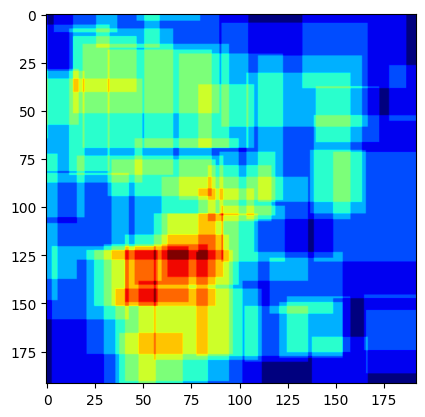

In [ ]:
#ライブラリをインポート
import matplotlib.pyplot as plt
import glob
import shutil

#このプログラム自体を動かすかどうかのスイッチ
cut_crear=True
#ヒートマップの画像を出力するか
ヒートマップ画像を出力=False#@param {type:"boolean"}
jet_out=ヒートマップ画像を出力

read_files_name_bbox='/content/cut/*.jpg'
read_files_bbox = glob.glob(read_files_name_bbox)
print("全画像の枚数はcutに",len(read_files_bbox),"枚")

#背景のみの画像（最後がbの画像の数を検索）
read_files_name_b='/content/cut/*_b.jpg'
read_files_b = glob.glob(read_files_name_b)

df = pd.read_csv('/content/cut_mask_bbox_fastlabel_cread.csv')
df2=df[~df.duplicated(subset='Name')]

if cut_crear==True:
  #アノテーションと画像の数が違うとtrain_test_splitが使えないのでアノテーションのある分だけ取り出す  
  #ラベルデータ読み取り
  anotation_name =df2["Name"]
  #フォルダ作成
  if os.path.exists('/content/cut_crear/'):
    shutil.rmtree('/content/cut_crear/')
    os.mkdir('/content/cut_crear/')
  else:
    os.mkdir('/content/cut_crear/')
  if os.path.exists('/content/annotations_not_mite/'):
    shutil.rmtree('/content/annotations_not_mite/')
    os.mkdir('/content/annotations_not_mite/')
  else:
    os.mkdir('/content/annotations_not_mite/')
  if os.path.exists('/content/annotations_not_mite_b/'):
    shutil.rmtree('/content/annotations_not_mite_b/')
    os.mkdir('/content/annotations_not_mite_b/')
  else:
    os.mkdir('/content/annotations_not_mite_b/')
  if os.path.exists('/content/cut_not_mite_b/'):
    shutil.rmtree('/content/cut_not_mite_b/')
    os.mkdir('/content/cut_not_mite_b/')
  else:
    os.mkdir('/content/cut_not_mite_b/')


  #コピー
  if os.path.exists('/content/cut_not_mite'):
    shutil.rmtree('/content/cut_not_mite')
    shutil.copytree('/content/cut','/content/cut_not_mite')
    #ダニがいる画像のみ移動
    for name in anotation_name:
      if not os.path.exists('/content/cut_crear/'+name):
        shutil.move('/content/cut_not_mite/'+name,'/content/cut_crear')

  if not os.path.exists('/content/cut_not_mite'):
    shutil.copytree('/content/cut','/content/cut_not_mite')
    #ダニがいる画像のみ移動
    for name in anotation_name:
      shutil.move('/content/cut_not_mite/'+name,'/content/cut_crear')
  
  #bのみコピー
  for name_file_b in read_files_b:
    shutil.copy2(name_file_b,'/content/cut_not_mite_b/')
    

  read_files_name_cut_crear='/content/cut_crear/*'
  read_files_cut_crear = glob.glob(read_files_name_cut_crear)
  read_files_name_cut_not='/content/cut_not_mite/*'
  read_files_cut_not = glob.glob(read_files_name_cut_not)
  read_files_name_cut_not_b='/content/cut_not_mite_b/*'
  read_files_cut_not_b = glob.glob(read_files_name_cut_not_b)
  print("害虫が映っている画像はcut_crearに",len(read_files_cut_crear),"枚")
  print("害虫が映っていない画像はcut_not_miteに",len(read_files_cut_not),"枚")
  #print("背景として出力された画像はcut_not_mite_bに",len(read_files_cut_not_b),"枚")
  
  read_files_name_bbox='/content/cutmask/*_[fo].png'
  read_files_bbox = glob.glob(read_files_name_bbox)

  #ダニがいない画像のアノテーションファイルを作成
  for imgname in read_files_cut_not:
    with open("/content/annotations_not_mite/"+os.path.basename(imgname).split('.', 1)[0]+".txt", "w") as f:
          rote=''
          f.write(rote)
  #背景アノテーションをコピー
  read_files_txt_b='/content/annotations_not_mite/*_b.txt'
  read_txt_b = glob.glob(read_files_txt_b)
  for name_txt_b in read_txt_b:
    shutil.copy2(name_txt_b,'/content/annotations_not_mite_b/')

if not os.path.exists('/content/heat/'):
  os.mkdir('/content/heat/')

read_files_name_annotation='/content/annotations/*'
read_files_annotation = glob.glob(read_files_name_annotation)
print("害虫のいるアノテーションはannotationsに",len(read_files_annotation),"枚")
read_files_name_annotations_not_mite='/content/annotations_not_mite/*'
read_files_annotations_not_mite= glob.glob(read_files_name_annotations_not_mite)
print("害虫のいないアノテーションはannotations_not_miteに",len(read_files_annotations_not_mite),"枚")
read_files_name_annotations_not_mite_b='/content/annotations_not_mite_b/*'
read_files_annotations_not_mite_b= glob.glob(read_files_name_annotations_not_mite_b)
#print("背景のアノテーションはannotations_not_mite_bに",len(read_files_annotations_not_mite_b),"枚")
read_files_name_annotations_yes_mite_b='/content/annotations/*_b.txt'
read_files_annotations_yes_mite_b= glob.glob(read_files_name_annotations_yes_mite_b)
#print("bのアノテーションがあるものがannotationsに",len(read_files_annotations_yes_mite_b),"枚")

fail_number=len(read_files_bbox)
heat=np.zeros_like(np.array(Image.open(read_files_bbox[0])),dtype=np.int16)
no_pixcel=0
yes_pixcel=0
all_pixcel=0

for file_name_bbox in read_files_bbox:
  img = np.array(Image.open(file_name_bbox))
  #色を二値化
  c = Image.fromarray(img).getcolors(Image.fromarray(img).width * Image.fromarray(img).height)
  #画像を足し合わせる
  img_binary = np.where(img == max(c)[1], 0, 1/fail_number)
  heat=heat+img_binary
  #画像比率を計算する
  img_binary_ratio = np.where(img == max(c)[1], 0, 1)
  no_pixcel=no_pixcel+np.count_nonzero(img_binary_ratio == 0)
  yes_pixcel=yes_pixcel+np.count_nonzero(img_binary_ratio == 1)
  all_pixcel=all_pixcel+img_binary_ratio.shape[0]*img_binary_ratio.shape[1]

print("画像中の背景の占める割合：画像中の害虫の占める割合＝",no_pixcel/all_pixcel,":",yes_pixcel/all_pixcel)
plt.imshow(heat, cmap='jet')
if jet_out==True:
  dst = cv2.applyColorMap((heat*255/heat.max()).astype('uint8'), cv2.COLORMAP_JET)
  cv2.imwrite('/content/jet_mite_potition.jpg', dst)

#**画像を保存する**
*   作成した画像を、学習に適したファイル構成に変えて保存する
*   保存場所はGoogle driveを使用する



In [ ]:
#@title １.画像を学習用とテスト用に分割
#ライブラリをインポート
import shutil
import os
from sklearn.model_selection import train_test_split
import math

#分割元のパスを作成
originals='/content/dataset_originals'
annotations='/content/dataset_annotations'
originals_not_mite='/content/dataset_originals_not_mite'
annotations_not_mite='/content/dataset_annotations_not_mite'

#分割先のパスを作成
train_images = '/content/dataset/mite/train/images'
train_labels = '/content/dataset/mite/train/labels'
valid_images = '/content/dataset/mite/valid/images'
valid_labels = '/content/dataset/mite/valid/labels'

#分割先のファイルを作成
if os.path.exists('/content/dataset/mite'):
  shutil.rmtree('/content/dataset/mite')
if not os.path.exists('/content/dataset/mite'):
  os.makedirs(train_images)
  os.makedirs(train_labels)
  os.makedirs(valid_images)
  os.makedirs(valid_labels)

#ファイルをコピー
if os.path.exists(originals):
  shutil.rmtree(originals)
if os.path.exists(annotations):
  shutil.rmtree(annotations)
if os.path.exists(originals_not_mite):
  shutil.rmtree(originals_not_mite)
if os.path.exists(annotations_not_mite):
  shutil.rmtree(annotations_not_mite)
if not os.path.exists(originals):
  shutil.copytree('/content/cut_crear',originals)
if not os.path.exists(annotations):
  shutil.copytree('/content/annotations',annotations)
if not os.path.exists(originals_not_mite):
  shutil.copytree('/content/cut_not_mite',originals_not_mite)
if not os.path.exists(annotations_not_mite):
  shutil.copytree('/content/annotations_not_mite',annotations_not_mite)

#フォルダの中のファイルのリストを作成
read_files_annotations = os.listdir(annotations)
read_files_annotations.sort()
read_files_originals= os.listdir(originals)
read_files_originals.sort()
read_files_annotations_not_mite = os.listdir(annotations_not_mite)
read_files_annotations_not_mite.sort()
read_files_originals_not_mite= os.listdir(originals_not_mite)
read_files_originals_not_mite.sort()

#@markdown 害虫のいる画像のうち何％をテスト用に分割するのかを定義
分割割合=0.2#@param {type:"slider", min:0, max:1, step:0.1}

#分割割合に合わせてファイルのリストを分割（害虫の映っていないファイルはすべてtrainに分配）
annotations_train, annotations_test, originals_train, originals_test = train_test_split(read_files_annotations,read_files_originals,test_size=分割割合)
annotations_train_not_mite=read_files_annotations_not_mite
originals_train_not_mite=read_files_originals_not_mite


#害虫がいる画像とアノテーションを分ける
for filename in annotations_train:
  shutil.copy( annotations+"/"+filename,train_labels)
for filename in annotations_test:
  shutil.copy( annotations+"/"+filename,valid_labels)
for filename in originals_train:
  shutil.copy( originals+"/"+filename,train_images)
for filename in originals_test:
  shutil.copy( originals+"/"+filename,valid_images)
#害虫がいない画像とアノテーションを分ける
for filename in annotations_train_not_mite:
  shutil.copy( annotations_not_mite+"/"+filename,train_labels)
for filename in originals_train_not_mite:
  shutil.copy( originals_not_mite+"/"+filename,train_images)

#最大公約数を計算
greatest_common_divisor=math.gcd(sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)),sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)))

#分割されたファイル数を表示
print("train/imagesは",sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)))
print("train/labelsは",sum(os.path.isfile(os.path.join(train_labels, name)) for name in os.listdir(train_labels)))
print("valid/imagesは",sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)))
print("valid/labelsは",sum(os.path.isfile(os.path.join(valid_labels, name)) for name in os.listdir(valid_labels)))
print("最大公約数は",greatest_common_divisor)

train/imagesは 98
train/labelsは 98
valid/imagesは 10
valid/labelsは 10
最大公約数は 2


##2.データを保存

In [ ]:
#@title 学習に必要なものを圧縮して保存
#ライブラリをインポート
import shutil
import os
from google.colab import files

#スイッチ
ファイルをグーグルドライブに保存=False#@param {type:"boolean"}
drive=ファイルをグーグルドライブに保存
ファイルをダウンロードする=True#@param {type:"boolean"}
direct=ファイルをダウンロードする

#圧縮
shutil.make_archive('/content/datasets', format='zip', root_dir='/content/dataset')
if drive==True:
  #グーグルドライブに接続
  from google.colab import drive
  drive.mount('/content/drive')
  #グーグルドライブにコピー
  shutil.copyfile("/content/datasets.zip","/content/drive/MyDrive/datasets.zip")
  
if direct==True:
  files.download("/content/datasets.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#つづきは…
AIの学習については、②AI学習について.ipynbに記載